In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import pymc as pm
import pymc.sampling_jax
import arviz as az
import warnings

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=Warning)

/Users/corrado/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")
sns.set_theme(palette="colorblind")

In [3]:
url = "https://raw.githubusercontent.com/washingtonpost/data-police-shootings/master/v2/fatal-police-shootings-data.csv"
fps_dat = pd.read_csv(url)
fps_dat.head()

,id,date,threat_type,flee_status,armed_with,city,county,state,latitude,longitude,location_precision,name,age,gender,race,race_source,was_mental_illness_related,body_camera,agency_ids
0,3,2015-01-02,point,not,gun,Shelton,Mason,WA,47.246826,-123.121592,not_available,Tim Elliot,53.0,male,A,not_available,True,False,73
1,4,2015-01-02,point,not,gun,Aloha,Washington,OR,45.487421,-122.891696,not_available,Lewis Lee Lembke,47.0,male,W,not_available,False,False,70
2,5,2015-01-03,move,not,unarmed,Wichita,Sedgwick,KS,37.694766,-97.280554,not_available,John Paul Quintero,23.0,male,H,not_available,False,False,238
3,8,2015-01-04,point,not,replica,San Francisco,San Francisco,CA,37.762910,-122.422001,not_available,Matthew Hoffman,32.0,male,W,not_available,True,False,196
4,9,2015-01-04,point,not,other,Evans,Weld,CO,40.383937,-104.692261,not_available,Michael Rodriguez,39.0,male,H,not_available,False,False,473


In [4]:
# Convert date
fps_dat["date"] = pd.to_datetime(fps_dat["date"])

# Create a new column 'year' to store the year information from the 'date' column
fps_dat["year"] = fps_dat["date"].dt.year

fps_dat.columns

Index(['id', 'date', 'threat_type', 'flee_status', 'armed_with', 'city',
       'county', 'state', 'latitude', 'longitude', 'location_precision',
       'name', 'age', 'gender', 'race', 'race_source',
       'was_mental_illness_related', 'body_camera', 'agency_ids', 'year'],
      dtype='object')

In [5]:
# Filter out rows with year equal to 2023
fps = fps_dat[fps_dat["year"] != 2023]

# Count occurrences of each year in fps
year_counts = fps["year"].value_counts()
print(year_counts)

year
2022    1096
2021    1048
2020    1019
2019     997
2015     995
2018     992
2017     983
2016     958
2024      60
Name: count, dtype: int64


In [6]:
# Define the data
data = {
    "year": [2022, 2021, 2020, 2019, 2015, 2018, 2017, 2016],
    "events": [1096, 1048, 1019, 997, 995, 992, 983, 958],
}
# Convert the data to a DataFrame
df = pd.DataFrame(data)
print(df)

   year  events
0  2022    1096
1  2021    1048
2  2020    1019
3  2019     997
4  2015     995
5  2018     992
6  2017     983
7  2016     958


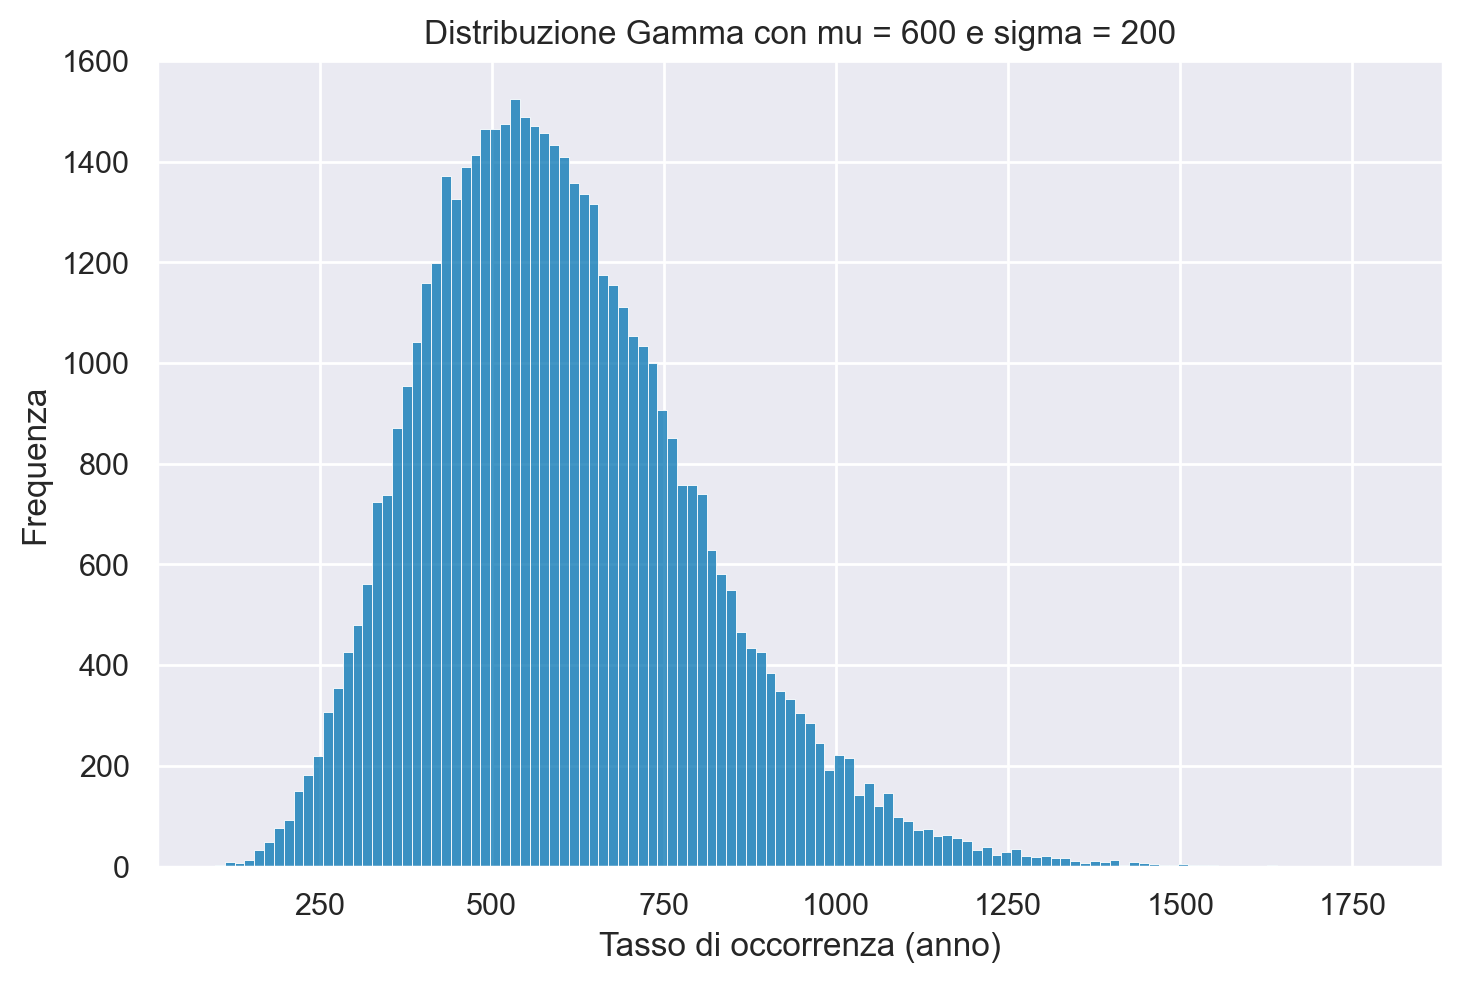

In [7]:
mu = 600  # mu hyperparameter for the Gamma prior
sigma = 200  # sigma hyperparameter for the Gamma prior

x = pm.Gamma.dist(mu=mu, sigma=sigma)
x_draws = pm.draw(x, draws=50000, random_seed=2)
sns.histplot(x_draws)

plt.xlabel("Tasso di occorrenza (anno)")
plt.ylabel("Frequenza")
plt.title("Distribuzione Gamma con mu = 600 e sigma = 200")
plt.show()

In [8]:
with pm.Model() as poisson_model:
    rate = pm.Gamma("rate", mu=mu, sigma=sigma)
    # Likelihood (Poisson) using the observed data
    y = df["events"].values
    events = pm.Poisson("events", mu=rate, observed=y)

In [9]:
# Use your model to sample from the prior
with poisson_model:
    idata_prior = pm.sample_prior_predictive()

Sampling: [events, rate]


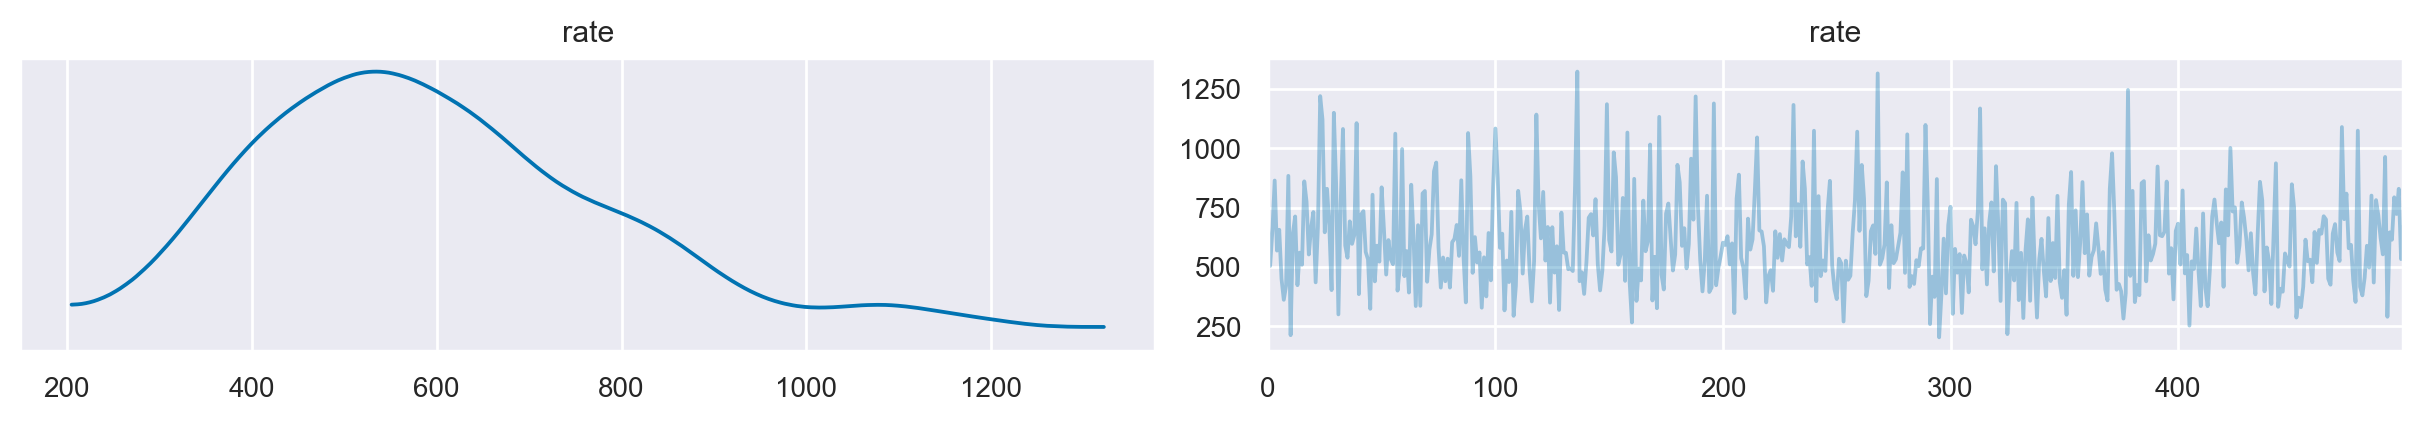

In [10]:
az.plot_trace(idata_prior.prior);

In [11]:
with poisson_model:
    idata = pm.sampling_jax.sample_numpyro_nuts()

Compiling...


Compilation time = 0:00:01.096445


Sampling...


  0%|                                                                                  | 0/2000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                    | 0/2000 [00:00<?, ?it/s]

  0%|                                                                                  | 0/2000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                    | 0/2000 [00:00<?, ?it/s]

  0%|                                                                                  | 0/2000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                    | 0/2000 [00:00<?, ?it/s]

  0%|                                                                                  | 0/2000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                    | 0/2000 [00:00<?, ?it/s]

Running chain 1:   0%|                                                                 | 0/2000 [00:01<?, ?it/s]

Running chain 3:   0%|                                                                 | 0/2000 [00:01<?, ?it/s]

Running chain 0:   0%|                                                                 | 0/2000 [00:01<?, ?it/s]

Running chain 2:   0%|                                                                 | 0/2000 [00:01<?, ?it/s]

Running chain 0: 100%|████████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1932.50it/s]


Running chain 1: 100%|████████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1934.62it/s]


Running chain 2: 100%|████████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1937.39it/s]


Running chain 3: 100%|████████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1940.15it/s]


Sampling time = 0:00:01.274469


Transforming variables...


Transformation time = 0:00:00.066985


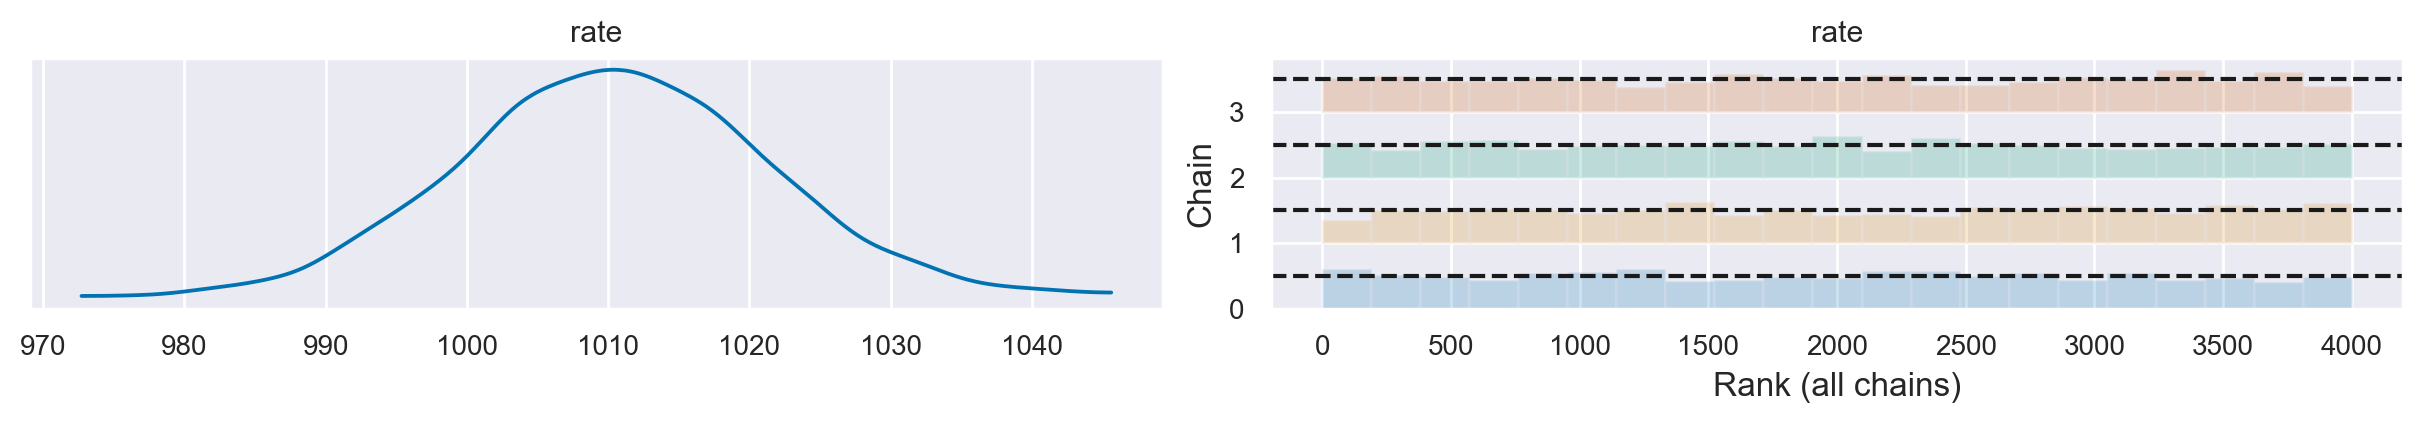

In [12]:
az.plot_trace(idata, combined=True, kind="rank_bars");

In [13]:
pm.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
rate,1010.358,10.908,989.279,1030.241,0.276,0.196,1555.0,2085.0,1.0


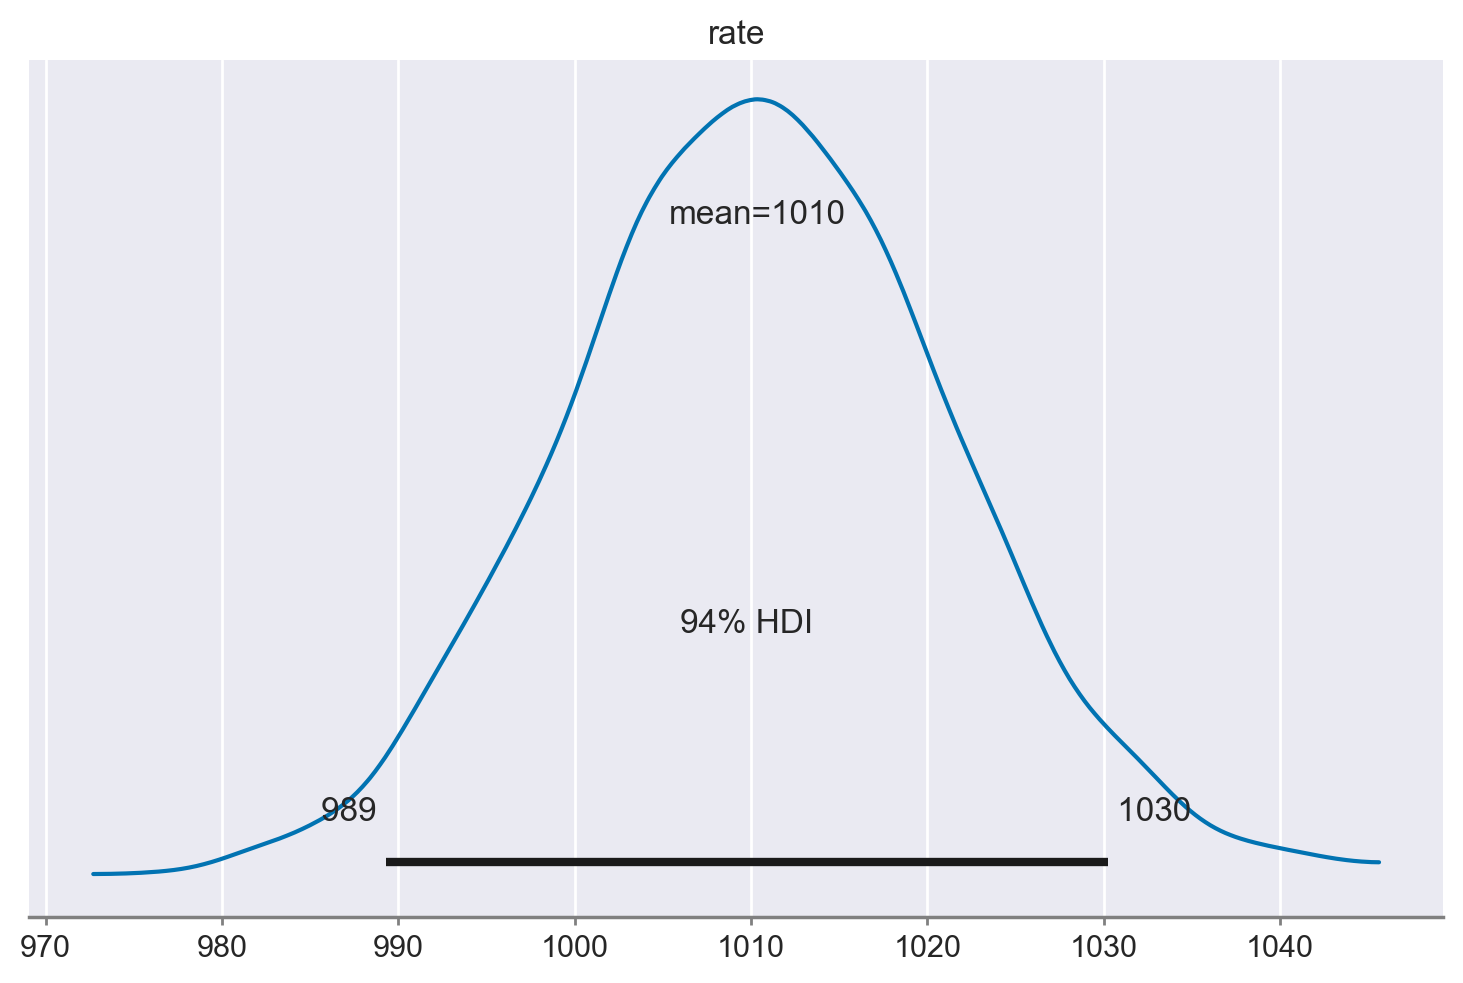

In [14]:
az.plot_posterior(idata, var_names="rate");

In [15]:
with poisson_model:
    pm.sample_posterior_predictive(idata, extend_inferencedata=True)

Sampling: [events]


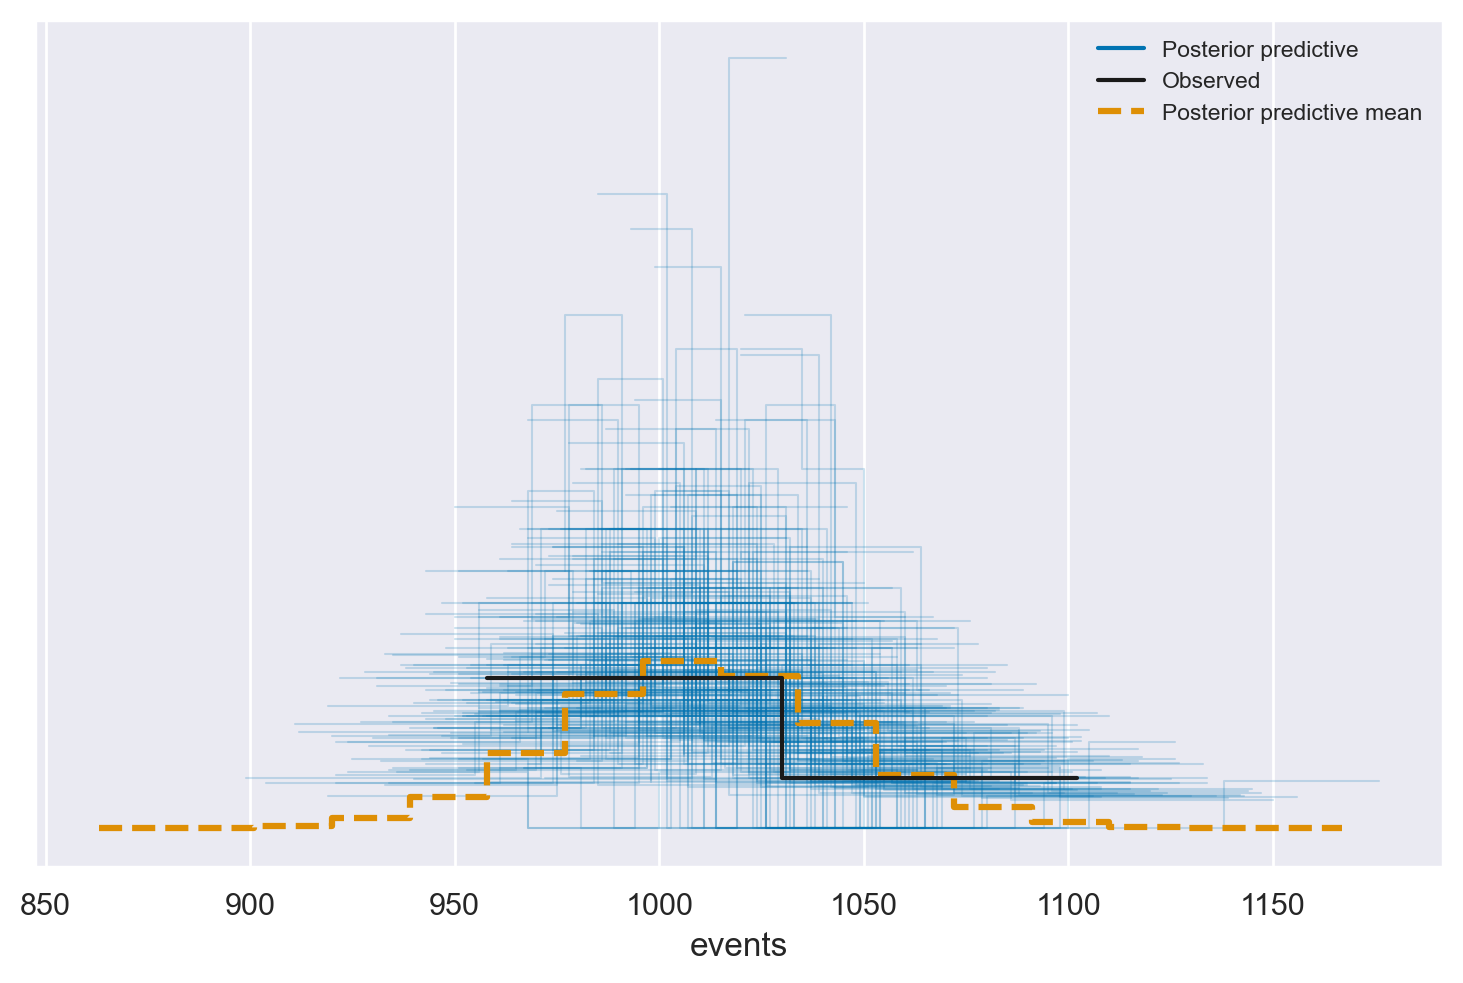

In [16]:
az.plot_ppc(idata, num_pp_samples=300);

In [17]:
data = [1096, 1048, 1019, 997, 995, 992, 983, 958]

# Prior hyperparameters
alpha_prior = 3
beta_prior = 1 / 200

# Data summary
n = len(data)
sum_y = np.sum(data)

# Posterior hyperparameters
alpha_post = alpha_prior + sum_y
beta_post = beta_prior + n

# Posterior distribution (Gamma)
posterior_gamma = stats.gamma(alpha_post, scale=1 / beta_post)

# Calculate the mean and credibility interval (94%)
posterior_mean = posterior_gamma.mean()
credible_interval = posterior_gamma.interval(0.94)

print("Estimated Rate (Posterior Mean):", posterior_mean)
print("Credibility Interval (94%):", credible_interval)

Estimated Rate (Posterior Mean): 1010.7432854465958
Credibility Interval (94%): (989.7152329772036, 1031.9826527942685)


In [18]:
%run ../wm.py

Watermark:
----------
Last updated: 2024-01-26T18:58:51.293717+01:00

Python implementation: CPython
Python version       : 3.11.7
IPython version      : 8.19.0

Compiler    : Clang 16.0.6 
OS          : Darwin
Release     : 23.3.0
Machine     : x86_64
Processor   : i386
CPU cores   : 8
Architecture: 64bit


